# Figure 11

This notebook solves a frost heave compaction problem in one spatial dimension (vertical). 

The code requires [FEniCSx](https://fenicsproject.org). The notebook can be run 
through a [Docker](https://www.docker.com) container with the command:

`docker run --init -ti -p 8888:8888 -v $(pwd):/home/fenics/shared -w /home/fenics/shared dolfinx/lab:stable`

Various imports:

In [1]:
%load_ext autoreload
%autoreload 2
# add path to code
import sys
sys.path.insert(0, '../source')

In [2]:
# !pip install --user ipyparallel

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import ipyparallel as ipp
import os 
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar

Start ipyparallel cluster for running a bunch of examples in parallel

In [ ]:
mycluster = ipp.Cluster(n = 20,timeout=180)
rc = mycluster.start_and_connect_sync()
view = rc.load_balanced_view()
dview = rc[:]
dview.block = True
dview.execute('import numpy as np')
dview.execute('import sys')
dview.execute('sys.path.insert(0, "../source")')
dview.execute('from wrapper import wrapper_gamma')

Compute solution for range of viscosity parameter (lamda) values

In [ ]:
from wrapper import wrapper_gamma

In [ ]:
lamda = np.arange(0,0.5004,0.005)   
gamma = lamda**2
v_i = 0.038
timesteps = np.linspace(0,8e3,8000)
mydict = dict(gamma=gamma,timesteps=timesteps,v_i=v_i)
dview.push(mydict);

wrapper_ = lambda i: wrapper_gamma(i,timesteps,v_i,gamma)
parameters = list(range(gamma.size))
async_results = []
for i in parameters:
    async_result = view.apply_async(wrapper_, i)
    async_results.append(async_result)

rc.wait_interactive(async_results)

results = [ar.get() for ar in async_results]

fname = 'results-gamma-38.npy'
res = {'results':results,'lamda':lamda}
np.save(fname,res)

In [4]:
import matplotlib as mpl

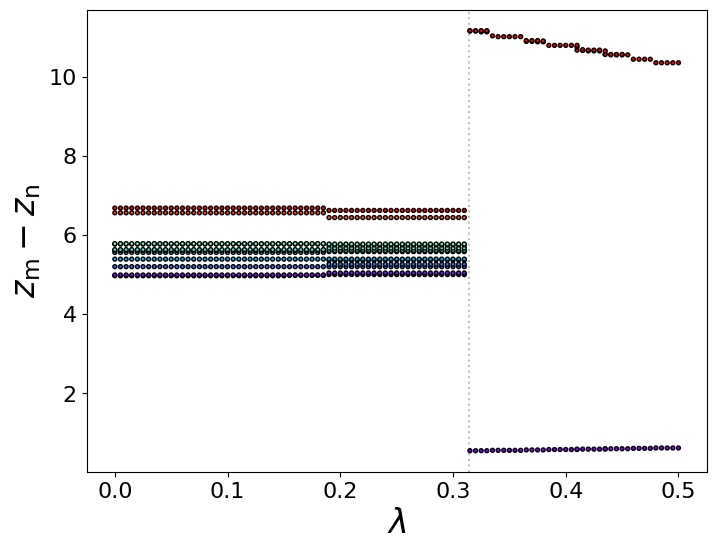

In [5]:
plt.figure(figsize=(8,6))
res = np.load('results-gamma-38.npy',allow_pickle=True).item()
results = res['results']
lamda = res['lamda']


for i in range(lamda.size):
    h = results[i][0][500:None]
    new_lens = results[i][1][500:None]
    old_lens = np.roll(new_lens,-1)
    jumps = h[old_lens==1] - h[new_lens==1]
    lamdas = lamda[i]*np.ones(h[old_lens==1].size)
    
    lamdas = lamdas[np.argsort(jumps)]
    jumps = np.sort(jumps)
    jumps, ind = np.unique(jumps.round(decimals=2),return_index=True)
    lamdas = lamdas[ind]
    
    # colors = plt.cm.Dark2(np.linspace(0,1,jumps.size+1))
    normalize = mpl.colors.Normalize(vmin=jumps.min(), vmax=jumps.max())
    # for j in range(lamdas.size):
    #     plt.plot([lamdas[j]],[jumps[j]],'o',color=colors[j],markersize=3)
    plt.scatter(lamdas,jumps,c=jumps,cmap='rainbow',norm=normalize,s=8,edgecolors='k')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.axvline(x=0.314,color='k',linestyle=':',alpha=0.25)
plt.ylabel(r'$z_\mathrm{m} - z_\mathrm{n} $',fontsize=24)
plt.xlabel(r'$\lambda$',fontsize=24) 
plt.savefig('Fig11')
plt.show()
plt.close()